# Model Prototyping Notebook

This notebook demonstrates how to prototype, train, and evaluate reinforcement learning agents for intraday futures trading using the custom RL infrastructure developed in this project.

**Pipeline stages:**
1. Import libraries and set up environment
2. Load processed features and configs
3. Instantiate RL environment and agent
4. Train agent with MLflow/TensorBoard logging
5. Evaluate and analyze results
6. Visualize and save outputs

In [1]:
# Imports, environment setup, and config loading
import sys
import os
from pathlib import Path
import importlib
import logging
import pandas as pd
import numpy as np

# Ensure project root is on sys.path so `src` imports resolve
proj_root = Path("/workspaces/RL_Intraday_Futures_Strategies")
if str(proj_root) not in sys.path:
    sys.path.insert(0, str(proj_root))

from src.utils.config import load_config
from src.utils.logging import setup_logger

logger = setup_logger(__name__, log_file=None)
logger.info('Model prototyping notebook started')

# Ensure working directory is project root so relative config paths resolve
os.chdir(str(proj_root))

# Load experiment and environment configs
env_cfg = load_config('env/futures_intraday')
cost_cfg = load_config('env/transaction_costs')
exp_cfg = load_config('experiment/dqn')
print('Loaded configs:', list(env_cfg.keys()), list(cost_cfg.keys()), list(exp_cfg.keys()))

2025-12-07 19:56:30 [INFO] __main__ - Model prototyping notebook started


Loaded configs: ['market', 'actions', 'reward'] ['costs', 'fees'] ['inherit', 'agent', 'training']


In [2]:
# Load processed features for RL (from feature engineering output)
from src.data.arcticdb_store import ArcticDBStore

# Connect to ArcticDB and list available symbols
project_db_path = proj_root / "financial_data"
db_store = ArcticDBStore(db_url=f"lmdb://{project_db_path}", library_name="futures_intraday")
available_symbols = db_store.list_symbols()
print(f"Available symbols in ArcticDB: {available_symbols}")

# Use the first available symbol, or raise an error if none exist
if not available_symbols:
    raise ValueError("No symbols found in ArcticDB library 'futures_intraday'. Please ingest data first.")
symbol = available_symbols[0]
data = db_store.read(symbol)
print(f"Loaded data for symbol: {symbol}, shape: {data.shape}")

Available symbols in ArcticDB: ['ENGINEERED/SAMPLE']
Loaded data for symbol: ENGINEERED/SAMPLE, shape: (2988, 21)


In [3]:
# Instantiate RL environment and agent
from src.envs.futures_env import FuturesTradingEnv
from src.envs.market_costs import linear_cost
from src.envs.reward_schemes import pnl_reward
from src.agents.dqn_agent import DQNAgent

# Prepare environment
cost_fn = lambda price, volume: linear_cost(price, volume, rate=cost_cfg.get('rate', 0.0005))
reward_fn = pnl_reward

env = FuturesTradingEnv(data, initial_balance=env_cfg.get('initial_balance', 1e6), cost_fn=cost_fn, reward_fn=reward_fn)

# Agent instantiation
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n
agent = DQNAgent(state_dim, action_dim, lr=exp_cfg.get('lr', 1e-3), gamma=exp_cfg.get('gamma', 0.99), log_dir="runs/model_prototyping", mlflow_experiment="RL_Experiment")

print(f"Environment and agent ready. State dim: {state_dim}, Action dim: {action_dim}")

2025/12/07 19:56:41 INFO mlflow.store.db.utils: Creating initial MLflow database tables...
2025/12/07 19:56:41 INFO mlflow.store.db.utils: Updating database tables
2025/12/07 19:56:41 INFO alembic.runtime.migration: Context impl SQLiteImpl.
2025/12/07 19:56:41 INFO alembic.runtime.migration: Will assume non-transactional DDL.
2025/12/07 19:56:41 INFO mlflow.store.db.utils: Updating database tables
2025/12/07 19:56:41 INFO alembic.runtime.migration: Context impl SQLiteImpl.
2025/12/07 19:56:41 INFO alembic.runtime.migration: Will assume non-transactional DDL.
2025/12/07 19:56:41 INFO alembic.runtime.migration: Context impl SQLiteImpl.
2025/12/07 19:56:41 INFO alembic.runtime.migration: Will assume non-transactional DDL.
2025/12/07 19:56:41 INFO alembic.runtime.migration: Context impl SQLiteImpl.
2025/12/07 19:56:41 INFO alembic.runtime.migration: Will assume non-transactional DDL.


Environment and agent ready. State dim: 24, Action dim: 3


In [4]:
# Ensure no MLflow run is active before training
import mlflow
while mlflow.active_run() is not None:
    mlflow.end_run()
print("All active MLflow runs ended.")

All active MLflow runs ended.


In [5]:
# Training loop with MLflow/TensorBoard logging
from src.training.train import train_agent
from src.training.callbacks import MLflowLogger, TensorBoardLogger, EarlyStopping, CheckpointSaver

callbacks = [
    MLflowLogger(experiment_name="RL_Experiment"),
    TensorBoardLogger(log_dir="runs/model_prototyping"),
    EarlyStopping(patience=10, min_delta=1e-2),
    CheckpointSaver(save_dir="checkpoints/model_prototyping")
]

# Optionally, split data for evaluation
train_len = int(len(data) * 0.8)
train_data = data.iloc[:train_len]
test_data = data.iloc[train_len:]

# Re-instantiate environment for training (train_data)
train_env = FuturesTradingEnv(train_data, initial_balance=env_cfg.get('initial_balance', 1e6), cost_fn=cost_fn, reward_fn=reward_fn)

# Train agent
train_agent(agent, train_env, n_episodes=exp_cfg.get('n_episodes', 50), callbacks=callbacks)


In [6]:
# Evaluate agent on test set and analyze results
from src.evaluation.evaluate import evaluate_agent, aggregate_metrics

test_env = FuturesTradingEnv(test_data, initial_balance=env_cfg.get('initial_balance', 1e6), cost_fn=cost_fn, reward_fn=reward_fn)
results = evaluate_agent(test_env, agent, n_episodes=5)
metrics = aggregate_metrics(results)
print("Evaluation metrics:", metrics)

Evaluation metrics: {'mean_total_reward': np.float64(-289070.100084677), 'std_total_reward': np.float64(4023.900626595201), 'mean_final_balance': np.float64(710929.899915323), 'std_final_balance': np.float64(4023.900626595201), 'action_distribution': array([0.03383585, 0.92830821, 0.03785595])}


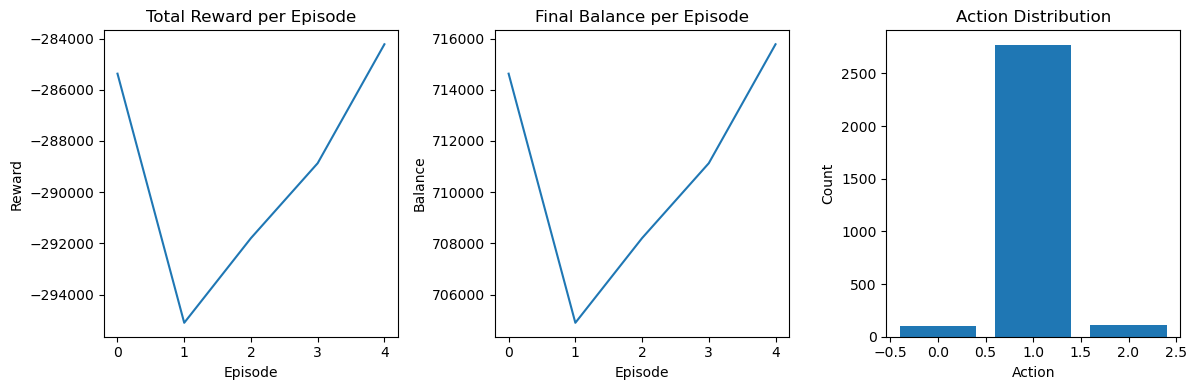

In [7]:
# Visualize results: rewards, balances, action distribution
import matplotlib.pyplot as plt
import numpy as np

rewards = [np.sum(r) for r in results['rewards']]
balances = [b[-1] for b in results['balances']]
actions = np.concatenate(results['actions'])

plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.plot(rewards)
plt.title('Total Reward per Episode')
plt.xlabel('Episode')
plt.ylabel('Reward')

plt.subplot(1, 3, 2)
plt.plot(balances)
plt.title('Final Balance per Episode')
plt.xlabel('Episode')
plt.ylabel('Balance')

plt.subplot(1, 3, 3)
plt.hist(actions, bins=np.arange(agent.action_dim+1)-0.5, rwidth=0.8)
plt.title('Action Distribution')
plt.xlabel('Action')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

In [8]:
# Save trained agent weights only (avoid pickling non-serializable objects)
import os
import re

os.makedirs('models', exist_ok=True)
safe_symbol = re.sub(r'[^a-zA-Z0-9_\-]', '_', symbol)
agent_path = f"models/dqn_agent_{safe_symbol}.pt"

if hasattr(agent, 'save') and callable(agent.save):
    agent.save(agent_path)
    print(f"Agent weights saved to {agent_path}")
elif hasattr(agent, 'model') and hasattr(agent.model, 'state_dict'):
    import torch
    torch.save(agent.model.state_dict(), agent_path)
    print(f"Model state_dict saved to {agent_path}")
else:
    print("Agent does not have a save method or model weights. Please implement a save method for your agent.")

Agent weights saved to models/dqn_agent_ENGINEERED_SAMPLE.pt


## Next Steps
- Experiment with different agents (PPO, custom policies)
- Tune hyperparameters and reward/cost functions
- Integrate additional diagnostics and risk metrics
- Use MLflow and TensorBoard for experiment tracking
- Extend to multi-asset and multi-agent scenarios

### 1. Experiment with PPO Agent
We will instantiate and train a PPO agent using the same environment and data pipeline.

In [9]:
# Instantiate and train PPO agent
from src.agents.ppo_agent import PPOAgent

ppo_agent = PPOAgent(state_dim, action_dim, lr=exp_cfg.get('lr', 1e-3), gamma=exp_cfg.get('gamma', 0.99))

ppo_callbacks = [
    MLflowLogger(experiment_name="RL_Experiment_PPO"),
    TensorBoardLogger(log_dir="runs/model_prototyping_ppo"),
    EarlyStopping(patience=10, min_delta=1e-2),
    CheckpointSaver(save_dir="checkpoints/model_prototyping_ppo")
]

train_agent(ppo_agent, train_env, n_episodes=exp_cfg.get('n_episodes', 50), callbacks=ppo_callbacks)

### 2. Hyperparameter Tuning and Reward/Cost Function Experiments
Try different learning rates, gamma values, and custom reward/cost functions to optimize agent performance.

In [10]:
# Example: Try a quadratic cost function and risk-adjusted reward
from src.envs.market_costs import quadratic_cost
from src.envs.reward_schemes import risk_adjusted_reward

quad_cost_fn = lambda price, volume: quadratic_cost(price, volume, rate=cost_cfg.get('rate', 0.0005), alpha=cost_cfg.get('alpha', 0.1))
risk_reward_fn = lambda balance, prev_balance, history: risk_adjusted_reward(balance, prev_balance, history, penalty=0.1)

# Re-instantiate environment with new cost/reward
custom_env = FuturesTradingEnv(train_data, initial_balance=env_cfg.get('initial_balance', 1e6), cost_fn=quad_cost_fn, reward_fn=lambda b, pb: risk_reward_fn(b, pb, [b, pb]))

# Train DQN agent with new environment
train_agent(agent, custom_env, n_episodes=10, callbacks=callbacks)

### 3. Integrate Additional Diagnostics and Risk Metrics
Use the evaluation and diagnostics modules to analyze agent robustness, risk, and regime changes.

In [11]:
# Example: Use diagnostics and risk metrics
from src.evaluation.diagnostics import trade_summary, detect_anomalies
from src.evaluation.risk_metrics import sharpe_ratio, max_drawdown, calmar_ratio, volatility

# Analyze test results
trade_stats = trade_summary([r for ep in results['rewards'] for r in ep])
sharpe = sharpe_ratio(rewards)
drawdown = max_drawdown(balances)
calmar = calmar_ratio(rewards, balances)
vol = volatility(rewards)

print('Trade stats:', trade_stats)
print('Sharpe:', sharpe, 'Max Drawdown:', drawdown, 'Calmar:', calmar, 'Volatility:', vol)

# Detect anomalies in rewards
detected = detect_anomalies(np.array(rewards))
print('Anomalous episodes:', detected)

Trade stats: {'count': 2985, 'win_rate': np.float64(0.03785594639865997), 'avg_pnl': np.float64(-484.2045227549029), 'max_pnl': np.float64(687.0463196410565), 'min_pnl': np.float64(-687.7337096558185), 'std_pnl': np.float64(240.77252024262862)}
Sharpe: -71.83828004434432 Max Drawdown: 0.013610800721124448 Calmar: -21238271.988899987 Volatility: 63877.44215044729
Anomalous episodes: []


### 4. Use MLflow and TensorBoard for Experiment Tracking
Visualize and compare experiment runs, hyperparameters, and metrics.

In [ ]:
# Launch MLflow and TensorBoard dashboards directly in the notebook
import threading
import time
import os
from IPython.display import display, HTML
import socket
def find_free_port():
    s = socket.socket()
    s.bind(('', 0))
    port = s.getsockname()[1]
    s.close()
    return port

# Start MLflow UI
mlflow_port = find_free_port()
def run_mlflow_ui():
    os.system(f"mlflow ui --backend-store-uri mlruns --port {mlflow_port}")

mlflow_thread = threading.Thread(target=run_mlflow_ui, daemon=True)
mlflow_thread.start()
time.sleep(3)  # Give server time to start
display(HTML(f'<a href="http://localhost:{mlflow_port}" target="_blank">Open MLflow UI</a>'))

# Start TensorBoard
tb_port = find_free_port()
def run_tensorboard():
    os.system(f"tensorboard --logdir runs --port {tb_port}")

tb_thread = threading.Thread(target=run_tensorboard, daemon=True)
tb_thread.start()
time.sleep(3)  # Give server time to start
display(HTML(f'<a href="http://localhost:{tb_port}" target="_blank">Open TensorBoard</a>'))

/opt/conda/envs/rl-intraday-futures/lib/python3.10/site-packages/tensorboard/default.py:30: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
TensorFlow installation not found - running with reduced feature set.
TensorFlow installation not found - running with reduced feature set.

NOTE: Using experimental fast data loading logic. To disable, pass
    "--load_fast=false" and report issues on GitHub. More details:
    https://github.com/tensorflow/tensorboard/issues/4784


NOTE: Using experimental fast data loading logic. To disable, pass
    "--load_fast=false" and report issues on GitHub. More details:
    https://github.com/tensorflow/tensorboard/issues/4784



Registry store URI not provided. Using backend store URI.


### 5. Extend to Multi-Asset and Multi-Agent Scenarios
Modify the environment and agent to support multiple assets and/or multiple agents for more realistic market simulations.

In [13]:
# Multi-asset and multi-agent environment setup example (state_dim=1 for price-only input)
from src.sim.market_simulator import MarketSimulator
from src.envs.futures_env import FuturesTradingEnv
from src.agents.dqn_agent import DQNAgent
from src.agents.ppo_agent import PPOAgent
import numpy as np
import pandas as pd

# Example: Generate or load multi-asset price data as a DataFrame (columns=assets, rows=time)
assets = ['ES', 'NQ', 'CL']
n_steps = 1000
multi_asset_data = pd.DataFrame({asset: np.random.randn(n_steps) for asset in assets})  # Replace with real data loading

# Create a market simulator for multiple assets
sim = MarketSimulator(multi_asset_data)

# Multi-agent setup: instantiate an agent per asset (state_dim=1 for price-only input)
action_dim = 3  # Example: 0=hold, 1=buy, 2=sell
agents = {asset: DQNAgent(1, action_dim, lr=1e-3, gamma=0.99) for asset in assets}

# Example training loop for multi-agent scenario
n_episodes = 10
for episode in range(n_episodes):
    sim.reset()
    done = {asset: False for asset in assets}
    obs = {asset: sim.get_observation(asset) for asset in assets}
    while not all(done.values()):
        actions = {}
        for asset in assets:
            if not done[asset]:
                # Pass price as a 1-element array for agent compatibility
                actions[asset] = agents[asset].act([obs[asset]])
        # Submit each action to the simulator (map action to side/volume)
        for asset in assets:
            if not done[asset]:
                action = actions[asset]
                if action == 1:  # buy
                    sim.submit_order(agent_id=asset, asset=asset, side='buy', volume=1)
                elif action == 2:  # sell
                    sim.submit_order(agent_id=asset, asset=asset, side='sell', volume=1)
                # action == 0: hold, do not submit order
        # Advance the simulator one step
        next_obs, rewards, dones, infos = sim.step()
        for asset in assets:
            if not done[asset]:
                # Store transitions as arrays for compatibility with agent update
                agents[asset].store_transition((np.array([obs[asset]]), actions[asset], rewards[asset], np.array([next_obs[asset]]), dones[asset], 1.0))
                obs[asset] = next_obs[asset]
                done[asset] = dones[asset]
    for asset in assets:
        agents[asset].update()
print('Multi-asset and multi-agent training complete. See MarketSimulator and agent classes for extension points.')

/opt/conda/envs/rl-intraday-futures/lib/python3.10/site-packages/mlflow/server/handlers.py:259: FutureWarning: The filesystem tracking backend (e.g., './mlruns') will be deprecated in February 2026. Consider transitioning to a database backend (e.g., 'sqlite:///mlflow.db') to take advantage of the latest MLflow features. See https://github.com/mlflow/mlflow/issues/18534 for more details and migration guidance.
  return FileStore(store_uri, artifact_uri)
/opt/conda/envs/rl-intraday-futures/lib/python3.10/site-packages/mlflow/server/handlers.py:288: FutureWarning: The filesystem model registry backend (e.g., './mlruns') will be deprecated in February 2026. Consider transitioning to a database backend (e.g., 'sqlite:///mlflow.db') to take advantage of the latest MLflow features. See https://github.com/mlflow/mlflow/issues/18534 for more details and migration guidance.
  return FileStore(store_uri)
[MLflow] Security middleware enabled with default settings (localhost-only). To allow connec

Multi-asset and multi-agent training complete. See MarketSimulator and agent classes for extension points.
